In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('Chinook.db')
cursor = conn.execute("select * from Artist LIMIT 10")
rows = cursor.fetchall()

rows

[(1, 'AC/DC'),
 (2, 'Accept'),
 (3, 'Aerosmith'),
 (4, 'Alanis Morissette'),
 (5, 'Alice In Chains'),
 (6, 'Antônio Carlos Jobim'),
 (7, 'Apocalyptica'),
 (8, 'Audioslave'),
 (9, 'BackBeat'),
 (10, 'Billy Cobham')]

In [2]:
data = ''
with open('Chinook_db_description.txt','r') as file:
    data= file.readlines()

text = " ".join(data)
print(text)


The Chinook database is a sample database used for learning and practicing SQL. It mimics a digital media store, including tables for artists, albums, media tracks, invoices, customers, and employees. Here's an overview of the schema:
 
 Tables and their columns:
 Artist
 
 ArtistId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Album
 
 AlbumId (INTEGER, Primary Key)
 Title (NVARCHAR)
 ArtistId (INTEGER, Foreign Key referencing Artist)
 Track
 
 TrackId (INTEGER, Primary Key)
 Name (NVARCHAR)
 AlbumId (INTEGER, Foreign Key referencing Album)
 MediaTypeId (INTEGER, Foreign Key referencing MediaType)
 GenreId (INTEGER, Foreign Key referencing Genre)
 Composer (NVARCHAR)
 Milliseconds (INTEGER)
 Bytes (INTEGER)
 UnitPrice (NUMERIC)
 MediaType
 
 MediaTypeId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Genre
 
 GenreId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Invoice
 
 InvoiceId (INTEGER, Primary Key)
 CustomerId (INTEGER, Foreign Key referencing Customer)
 InvoiceDate (DATETIME)
 BillingAddress (

In [3]:
import openai
from openai import OpenAI
from dotenv import load_dotenv, dotenv_values 
from PIL import Image
from io import BytesIO
import time
import pandas as pd
import datetime

load_dotenv()
client = OpenAI()


In [4]:
user_query = "Create a plot of the total spend of the top 10 users. Use vertical labels for the x axis"
#user_query = "What is the total spend per user"

In [5]:
schema_template = "Here is the schema of a database. "+text\
    +"\n Write a SQL query to answer the following question. Provide only the SQL and nothing else\n"
user_request = schema_template+user_query
print(user_request)

Here is the schema of a database. The Chinook database is a sample database used for learning and practicing SQL. It mimics a digital media store, including tables for artists, albums, media tracks, invoices, customers, and employees. Here's an overview of the schema:
 
 Tables and their columns:
 Artist
 
 ArtistId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Album
 
 AlbumId (INTEGER, Primary Key)
 Title (NVARCHAR)
 ArtistId (INTEGER, Foreign Key referencing Artist)
 Track
 
 TrackId (INTEGER, Primary Key)
 Name (NVARCHAR)
 AlbumId (INTEGER, Foreign Key referencing Album)
 MediaTypeId (INTEGER, Foreign Key referencing MediaType)
 GenreId (INTEGER, Foreign Key referencing Genre)
 Composer (NVARCHAR)
 Milliseconds (INTEGER)
 Bytes (INTEGER)
 UnitPrice (NUMERIC)
 MediaType
 
 MediaTypeId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Genre
 
 GenreId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Invoice
 
 InvoiceId (INTEGER, Primary Key)
 CustomerId (INTEGER, Foreign Key referencing Customer)
 Invoic

In [6]:
def llm_request(user_prompt):
    completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You helpful data analyst.Use only the information provided in the text."},
        {"role": "user", "content": user_prompt}
    ]
    )

    result = completion.choices[0].message.content
    return result


In [7]:
result = llm_request(user_request)
my_SQL = result[7:-3]
print(my_SQL)

df = pd.read_sql(my_SQL,conn)
df.head()

SELECT c.CustomerId, c.FirstName || ' ' || c.LastName AS CustomerName, SUM(i.Total) AS TotalSpend
FROM Customer c
JOIN Invoice i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId, CustomerName
ORDER BY TotalSpend DESC
LIMIT 10;



,CustomerId,CustomerName,TotalSpend
0,6,Helena Holý,49.62
1,26,Richard Cunningham,47.62
2,57,Luis Rojas,46.62
3,45,Ladislav Kovács,45.62
4,46,Hugh O'Reilly,45.62


In [28]:
request = "Here is a sample dataframe\n "+ df.head(10).to_string() \
    + "\n Provide only Python code to answer the question and nothing else. "\
    + "Assume that the data is available in a dataframe df, and use only data from the sample provided. "\
    + "Don't include any data in the code. "\
    + "Any plots should have a size of 10,5 and a dpi of 300. \
      Use seaborn to generate the plots, if possible. Save the image as a png in the \
        current directory with the name plot_image.png\
        Question: "
request += user_query
print(request)

import os
os.getcwd()

Here is a sample dataframe
    CustomerId        CustomerName  TotalSpend
0           6         Helena Holý       49.62
1          26  Richard Cunningham       47.62
2          57          Luis Rojas       46.62
3          45     Ladislav Kovács       45.62
4          46       Hugh O'Reilly       45.62
5          28       Julia Barnett       43.62
6          24       Frank Ralston       43.62
7          37     Fynn Zimmermann       43.62
8           7       Astrid Gruber       42.62
9          25      Victor Stevens       42.62
 Provide only Python code to answer the question and nothing else. Assume that the data is available in a dataframe df, and use only data from the sample provided. Don't include any data in the code. Any plots should have a size of 10,5 and a dpi of 300.       Use seaborn to generate the plots, if possible. Save the image as a png in the         current directory with the name plot_image.png        Question: Create a plot of the total spend of the top 10 users. 

'h:\\Development\\Python\\DataChat\\SQL_Plot_with_LLM'

In [82]:
current_path = os.getcwd()
filepath = os.path.join(current_path,"plot_image.png")
filepath

'h:\\Development\\Python\\DataChat\\SQL_with_LLM\\plot_image.png'

In [29]:
result = llm_request(request)
#print(result)
code = result[10:-3]
print(code)

import matplotlib.pyplot as plt
import seaborn as sns

top_10_users = df.nlargest(10, 'TotalSpend')
plt.figure(figsize=(10, 5), dpi=300)
sns.barplot(y='CustomerId', x='TotalSpend', data=top_10_users)
plt.xlabel('Total Spend')
plt.ylabel('Customer ID')
plt.savefig('plot_image.png')



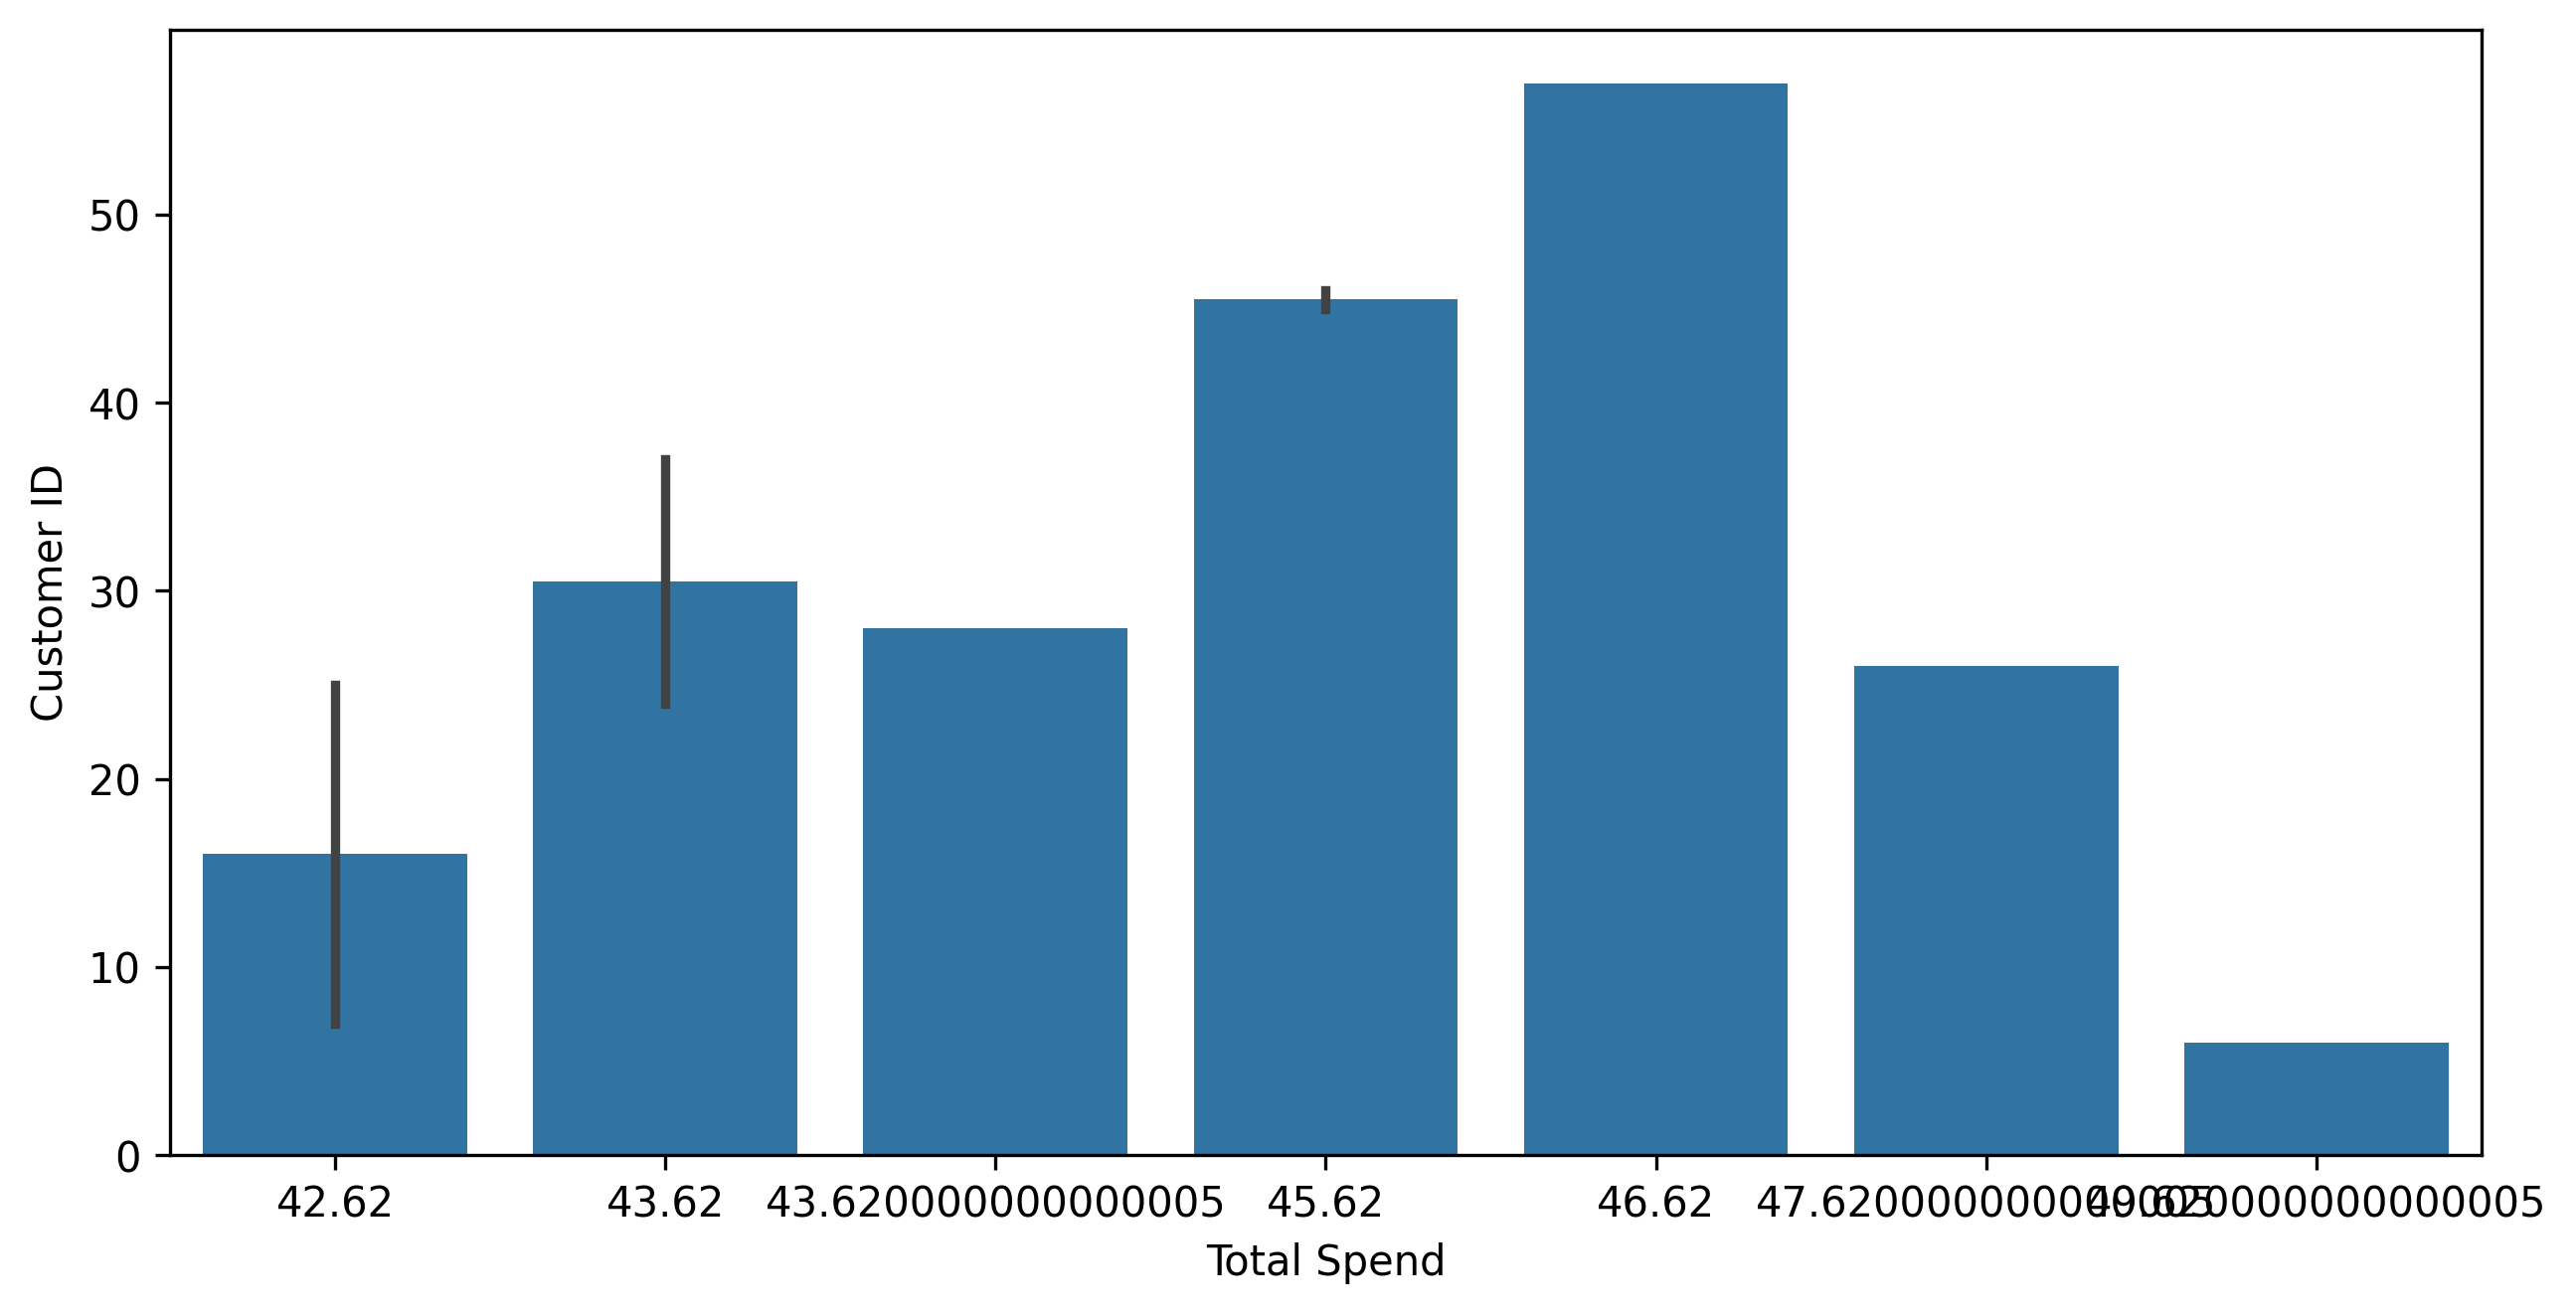

In [30]:
max_tries = 5
tries = 0
while tries < max_tries:
    try:
        exec(code)
        break
    except Exception as e:
        tries +=1
        print(e)

In [10]:
df.columns

Index(['CustomerId', 'CustomerName', 'TotalSpend'], dtype='object')

In [33]:
code = """
import matplotlib.pyplot as plt
import seaborn as sns

top_10_users = df.nlargest(10, 'TotalSpend')
plt.figure(figsize=(10, 5), dpi=300)
sns.barplot(y='CustomerId', x='TotalSpend', data=top_10_users)
plt.xlabel('Total Spend')
plt.ylabel('Customer ID')
#plt.savefig('plot_image.png')
#output = plt.savefig('plot_image.png')
# """

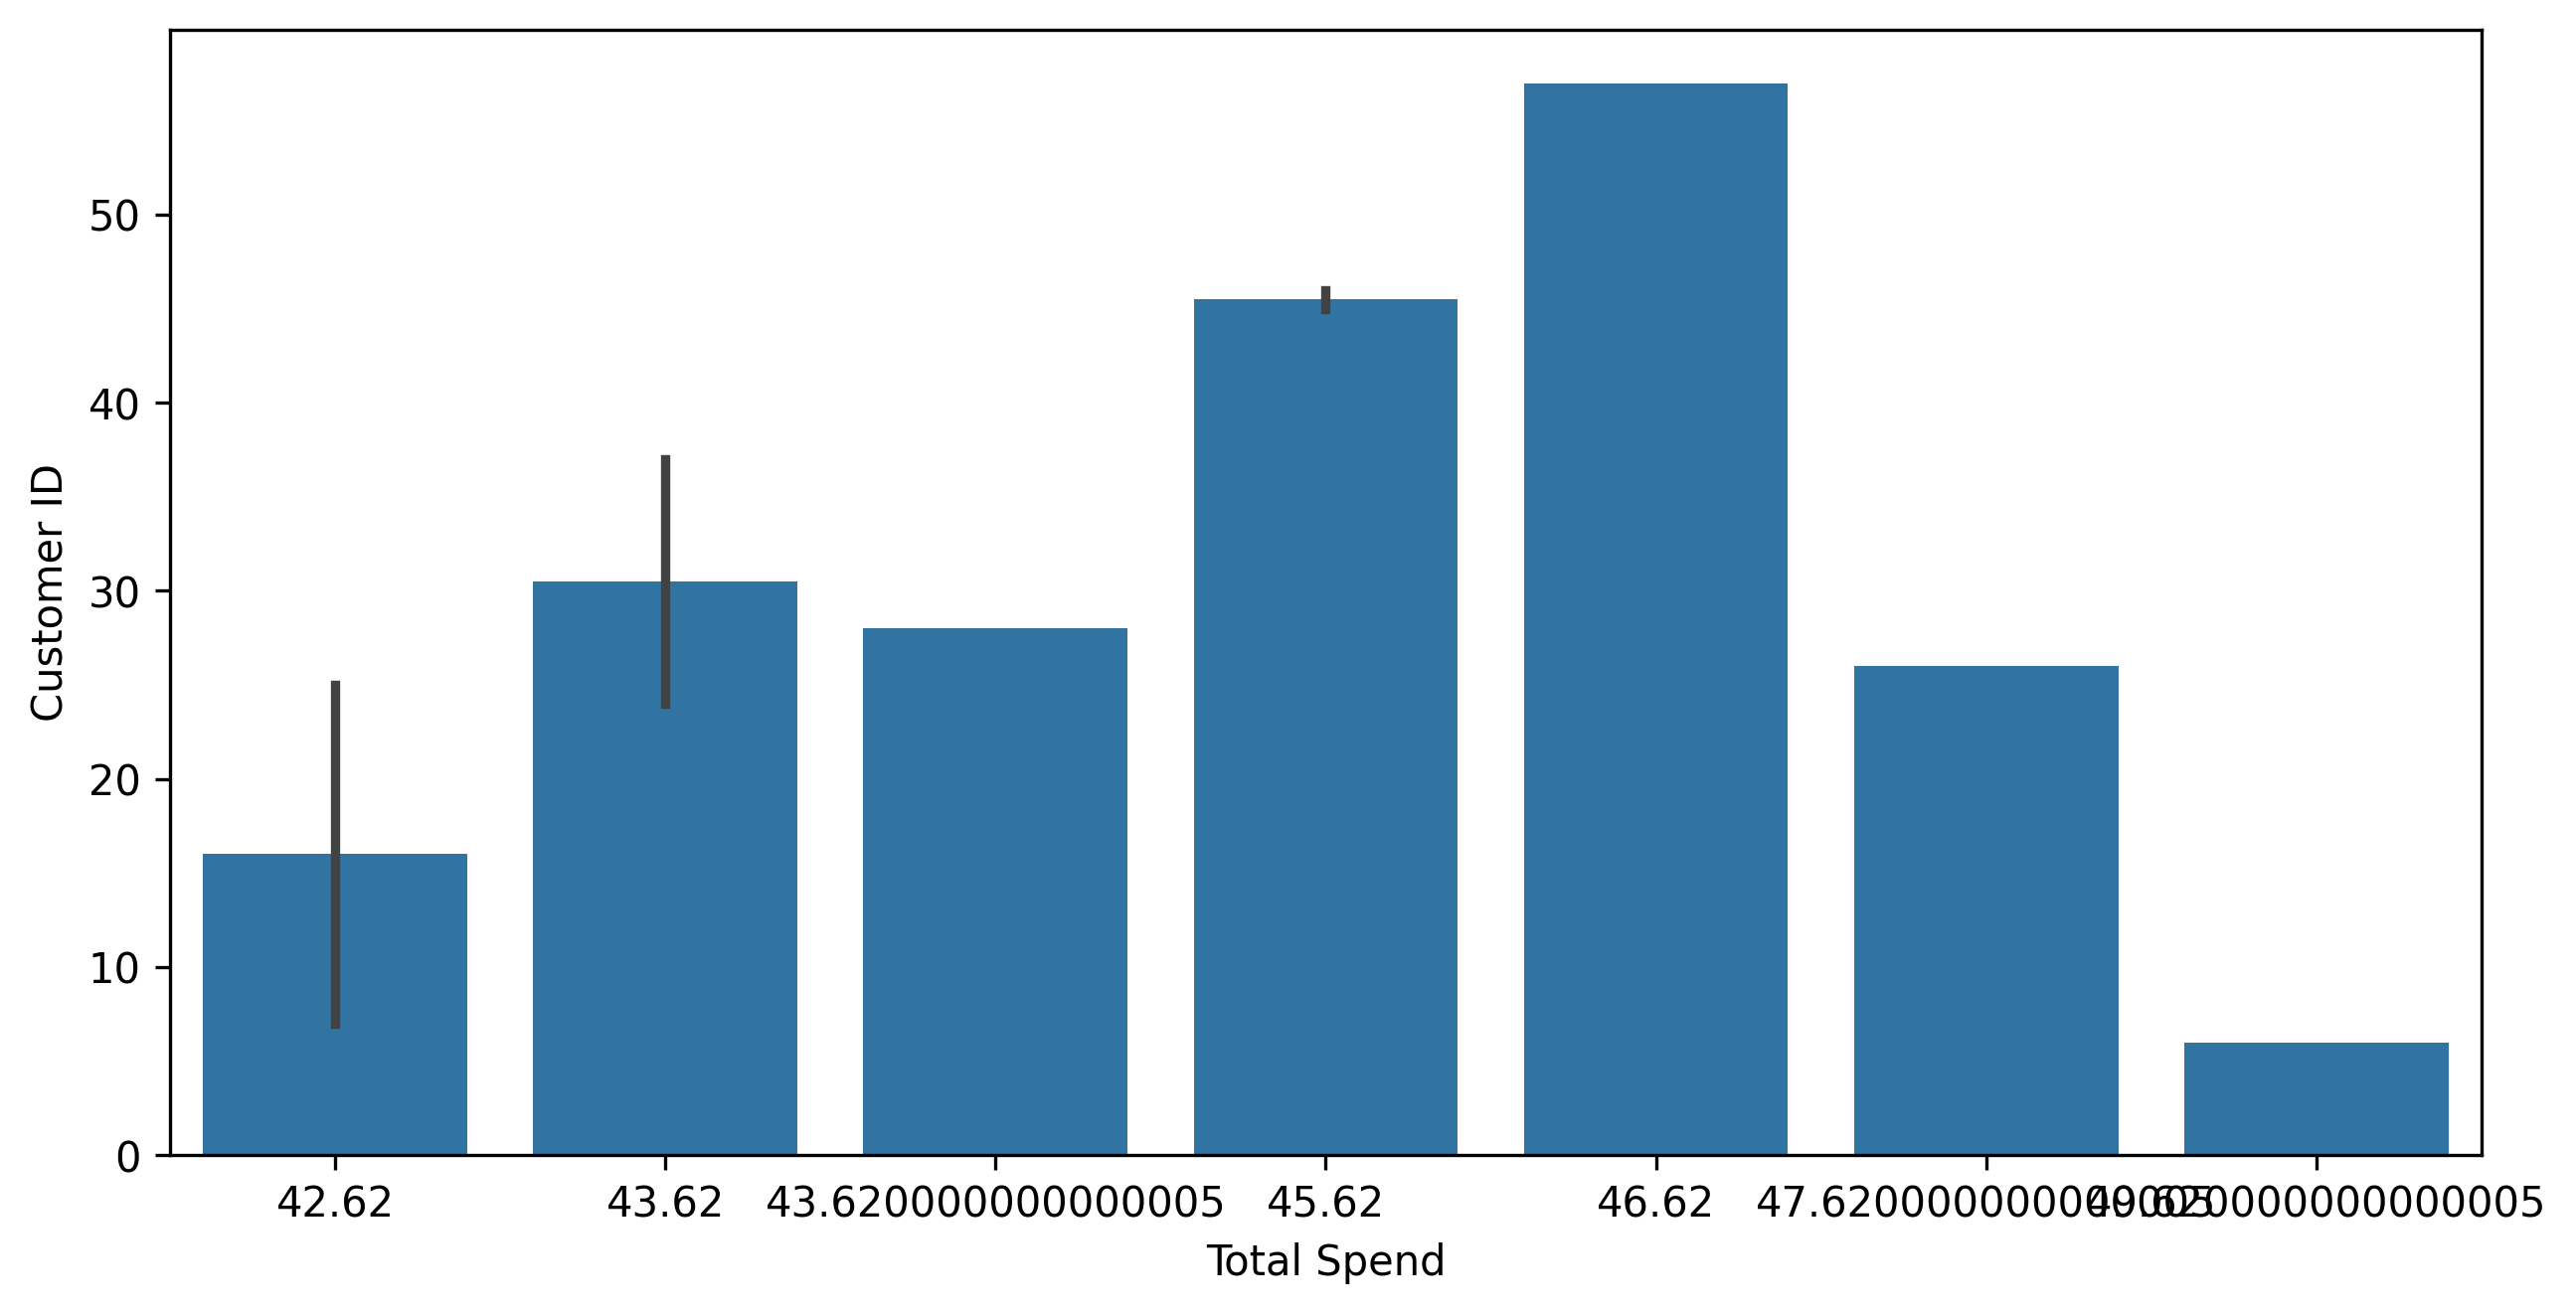

In [34]:
exec(code,{'df':df})


In [20]:
obj = ["apple", "cherry", "melon", "strawberry"]
code = "print([sliced[:4] for sliced in items if 'a' not in sliced])"
#exec("print([sliced[:4] for sliced in obj if 'a' not in sliced])")
#-----------------------------OR--------------------------------
#Eexec("result = [sliced[:4] for sliced in obj if 'a' not in sliced]")
#result

exec("result" = code,{'items':obj})

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (3900649916.py, line 8)